In [1]:
%matplotlib inline
import artm
import matplotlib.pyplot as plt
from matplotlib import colors
print(artm.version())

0.8.1


In [2]:
MODELS_NUMBER = 3
#all_colors = list(colors.cnames.keys())
all_colors = ['red', 'green', 'blue']

In [3]:
vectorizers = []
dictionaries = []
for i in range(MODELS_NUMBER):
    vectorizers.append(
        artm.BatchVectorizer(gather_dictionary=True, data_format='vowpal_wabbit', data_path='../rss_texts.vw', target_folder="rss_batches")
    )
    dictionaries.append(vectorizers[-1].dictionary)

In [4]:
scores = []
for i in range(MODELS_NUMBER):
    scores.append([
        artm.SparsityPhiScore(name='SparsityPhiScore'),
        artm.SparsityThetaScore(name='SparsityThetaScore'),
        artm.TopTokensScore(name='TopTokensScore', num_tokens=20, dictionary=dictionaries[i], class_id='rss'),
        artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3, dictionary=dictionaries[i]),
        artm.PerplexityScore(name='PerplexityScore', use_unigram_document_model=False, dictionary=dictionaries[i])
    ])

In [5]:
regularizers = [
    [
        artm.SmoothSparsePhiRegularizer(name='SmootSparsePhi', tau=-0.2),
        artm.SmoothSparseThetaRegularizer(name='SmootSparseTheta', tau=-0.15)
    ],
    [
        artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2)
    ],
    [
        artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi')
    ]
]

In [6]:
models = []
for i in range(MODELS_NUMBER):
    models.append(
        artm.ARTM(num_topics=100, cache_theta=True, scores=scores[i], regularizers=regularizers[i])
    )
    models[-1].initialize(dictionary=dictionaries[i])

In [7]:
for i in range(MODELS_NUMBER):
    models[i].fit_offline(batch_vectorizer=vectorizers[i], num_collection_passes=10)

Sparsity Phi: [nan, nan, nan]
Sparsity Theta: [0.8914678090967328, 0.08410794362588085, 0.08410634208840487]
Kernel contrast: [0.0, 0.0, 0.0]
Kernel purity: [0.0, 0.0, 0.0]
Perplexity: [1628.1435074512874, 1191.6616596405272, 1191.6622082896913]
Colors: ['red', 'green', 'blue']


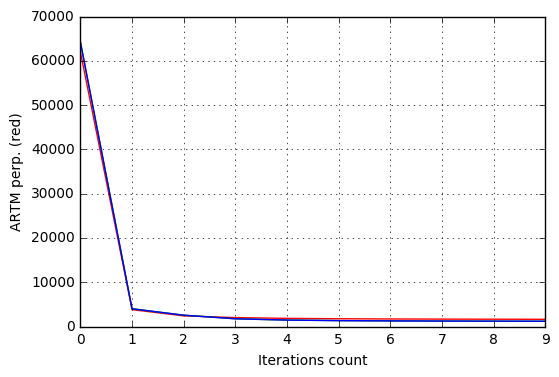

In [8]:
sparsity_phi = []
sparsity_theta = []
kernel_kontrasts = []
kernel_purity = []
perplexity = []
m_colors = []
lines = []
for i in range(MODELS_NUMBER):
    sparsity_phi.append(models[i].score_tracker['SparsityPhiScore'].last_value)
    sparsity_theta .append(models[i].score_tracker['SparsityThetaScore'].last_value)
    kernel_kontrasts.append(models[i].score_tracker['TopicKernelScore'].last_average_contrast)
    kernel_purity.append(models[i].score_tracker['TopicKernelScore'].last_average_purity)
    perplexity.append(models[i].score_tracker['PerplexityScore'].last_value)
    lines.append(range(models[i].num_phi_updates))
    lines.append(models[i].score_tracker['PerplexityScore'].value)
    lines.append(all_colors[i])
    m_colors.append(all_colors[i])
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp. (red)')
print('Sparsity Phi: {}'.format(sparsity_phi))
print('Sparsity Theta: {}'.format(sparsity_theta))
print('Kernel contrast: {}'.format(kernel_kontrasts))
print('Kernel purity: {}'.format(kernel_purity))
print('Perplexity: {}'.format(perplexity))
print('Colors: {}'.format(m_colors))
plt.plot(*lines, linewidth=1)
plt.grid(True)
plt.show()

Colors: ['red', 'green', 'blue']


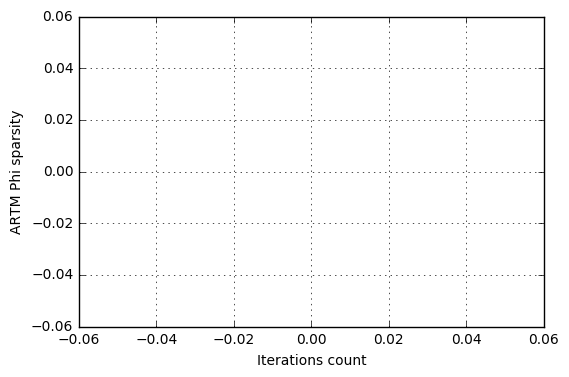

Colors: ['red', 'green', 'blue']


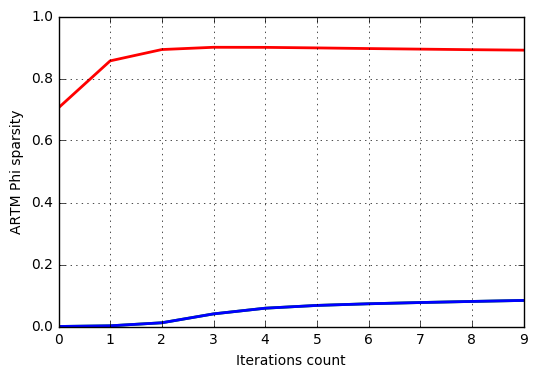

In [9]:
lines = []
m_colors = []
for i in range(MODELS_NUMBER):
    lines.append(range(models[i].num_phi_updates))
    lines.append(models[i].score_tracker['SparsityPhiScore'].value)
    lines.append(all_colors[i])
    m_colors.append(all_colors[i])
print('Colors: {}'.format(m_colors))
plt.plot(*lines, linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sparsity')
plt.grid(True)
plt.show()

lines = []
m_colors = []
for i in range(MODELS_NUMBER):
    lines.append(range(models[i].num_phi_updates))
    lines.append(models[i].score_tracker['SparsityThetaScore'].value)
    lines.append(all_colors[i])
    m_colors.append(all_colors[i])
print('Colors: {}'.format(m_colors))
plt.plot(*lines, linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sparsity')
plt.grid(True)
plt.show()

In [10]:
for topic_name in models[0].topic_names:
    print topic_name, ':'
    for i in range(MODELS_NUMBER):
        print 'model_{}: '.format(i),
        for token in models[i].score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print token, ',',
        print('\n')
    print('\n')

topic_0 :
model_0:  петербург , обязанность , дело , санкт , исполнять , евгений , собака , никто , александр , случиться , олег , готовить , это , который , собеседник , человек , петербургский , проводить , медведев , доска , 

model_1:  человек , пытаться , дело , делать , весь , видеть , почему , просто , самый , это , никто , знать , большой , очень , обязанность , часто , кома , кажется , случай , который , 

model_2:  человек , пытаться , дело , делать , весь , видеть , почему , просто , самый , это , никто , знать , большой , очень , обязанность , часто , кома , кажется , случай , который , 



topic_1 :
model_0:  что , ребёнок , в , образование , страна , свой , за , это , предлагать , зарплата , не , отношение , учиться , с , родитель , школа , наш , предложить , и , считать , 

model_1:  в , и , не , что , на , это , с , я , год , сбор , за , а , по , весь , зарплата , предлагать , свой , быть , от , который , 

model_2:  в , и , не , что , на , это , с , я , год , сбор , за